In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import trainer
from trainer import device

In [11]:
# load dictionary (100k words) from /usr/share/dict/words
with open('/usr/share/dict/words', 'r') as f:
    vocab = {}
    for line in f:
        word = line.strip().replace("'","").lower()
        if not word in vocab:
            vocab[word] = len(vocab)

words = sorted(vocab.keys(), key=lambda w: vocab[w])

assert(len(words) == len(vocab))
assert(vocab[words[42]] == 42)

In [12]:
# given a sentence, parse it into word indices
import re
phrase_re = re.compile(r'[!.;()"\']+')
word_re = re.compile(r'[,\s-]+')

def sentences(str):
    return [[w.lower() for w in word_re.split(p) if len(w) > 0] for p in phrase_re.split(str.lower())]

In [27]:
import json
import random
import os.path

# given a JSON file (with review data), endlessly produce reviews from random offsets
# each review is a list of word indices, padded with -1 to a given length to simplify batch collation
class ReviewDataset(D.IterableDataset):
    def __init__(self, path, limit):
        super().__init__()
        self.file = open(path, 'r', errors='ignore')
        self.size = os.path.getsize(path)
        self.limit = limit
    def __iter__(self):
        while True:
            offset = random.randrange(self.size)
            self.file.seek(offset, 0)
            line = self.file.readline()
            line = self.file.readline() # note: we read the line twice, because the first line is probably incomplete
            try:
                review = json.loads(line)
                if not 'overall' in review or not 'reviewText' in review:
                    continue
                score = float(review["overall"])
                text = review["reviewText"]
                words = [vocab[w] for s in sentences(text) for w in s if w in vocab]
                if len(words) < self.limit:
                    words += [-1] * (self.limit - len(words))
                else:
                    words = words[:self.limit]
                yield torch.tensor(words, dtype=torch.long), torch.tensor(score, dtype=torch.float)
            except json.JSONDecodeError:
                continue

In [14]:
# load word2vec embeddings that we've trained; note that they must match the word dictionary
w2v = torch.load("w2v.pt", weights_only=True)
assert(w2v.shape[0] == len(vocab))

/home/zeux/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [15]:
# define a model that takes a sequence of word indices and outputs a score
class Net(nn.Module):
    def __init__(self, w2v, hidden_size, num_layers):
        super().__init__()
        self.w2v = nn.Embedding.from_pretrained(w2v, freeze=True)
        self.rnn = nn.LSTM(w2v.shape[1], hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # for now, replace -1 (padding) with 0 as embedding doesn't handle it
        # this will effectively replace padding with 'a', which is a useless word... maybe it would be better to replace embedding with a zero vector?
        x[x == -1] = 0

        x = self.w2v(x) # -> BxLxV
        x, _ = self.rnn(x) # -> BxLxH
        # note: this needs to change for bidirectional RNNs, but for now take last output
        x = x[:, -1, :] # -> BxH
        # final classifier
        x = self.fc(x).flatten() # -> B
        x = F.sigmoid(x)
        return x
    def loss(self, pred, y):
        # y is in range 1..5, so we need to convert it to 0..1
        # TODO: not sure MSE loss is great? could try binary CE instead
        return F.mse_loss(pred, (y - 1) / 4)

Train [28.399M params]: 100 epochs took 5234.46 sec, train loss 0.017124, val loss 0.000000


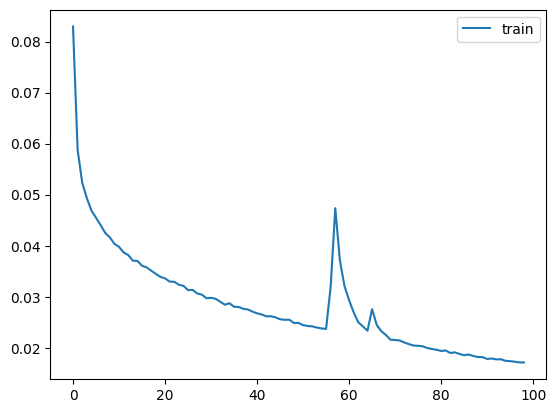

In [36]:
net = Net(w2v, 512, 3).to(device)
data = D.DataLoader(ReviewDataset("../movie-ratings.json", 128), batch_size=256, num_workers=4)
trainer.train(net, data, epochs=100, batch_limit=1000)

In [51]:
def score(net, text, limit=128):
    words = [vocab[w] for s in sentences(text) for w in s if w in vocab]
    if limit:
        if len(words) < limit:
            words += [-1] * (limit - len(words))
        else:
            words = words[:limit]
    words = torch.tensor(words, dtype=torch.long).unsqueeze(0).to(device)
    return net(words)[0].item() * 4 + 1

In [54]:
score(net, """
Delivers a best high octane action thriller from the franchise .

Pros - There was bit let down in JW3 , but they came back with a banger JW4 and delivered one of the best actions of all time . Stunt choreography , Camera work , editing and heart pumping BGMs were totally bonkers . There were many prolonged action sequences through out the movie , each of them never fails to deliver some thrill and adrenaline rush . Besides from action set pieces , JW4 well contributed in the world building and this whole tetralogy done a good job in World building & character establishments , I hope it will be well used in its upcoming spin off series and movies . Cast did great job , especially Keanu Reeves and Donie Yen were great .

Cons - Few silly logical mistakes that you can't ignore .

Overall , to the action lovers and John wick fans out there don't miss out to watch it on big screen . Must watch . Highly recommended .
""")

4.11601185798645

In [53]:
score(net, """
I am not sure what I have watched. Seriously, I'm in schock lol... I am a big fan of slashers so that's why I've watched almost all the great and the surreal ones too. This movie is on the top list of the worst. But, let me tell you something, if you want to watch a slasher starring Winne the Poh you can't expect an Oscar winning here. But I think it could have been far better with a more serious script and actors.

First, the movie is maximum a Z one. It is bad, really bad in all aspects. Even the gore looked pretty cheap.

Second, the music is terrible. As bad as you can expect in a Z++++ movie.

Last but not least, the best are the girls ready to dissapear. Didn't feel anything for any of them. Good job Winnie and friends.

So, overall if you want to waste some time watching a terrible slasher, do it. Even you can find somehow entertaining if you're in the mood.
""")

1.6622163653373718

In [52]:
score(net, """
At this point, "The Avengers" has made around 100 trillion dollars (or so)--and so it's obvious that people love the film.
My own daughter went to the premier in New York and then went to it on opening night in general release--and was mad I didn't take her with me tonight to see it!
Obviously, she loved the film as well. As for me, I liked it but didn't quite share the overall exuberance for the film.
Mind you, I liked it--but I think I preferred the earlier films before the Avengers team was formed.
There was a certain charm that I didn't quite see recaptured in the film. Now the film is good--it's just that what I like in these other films I would have liked more of in "The Avengers".
Specifically, the movie could have used a bit more humor and a bit more character development. When I read the IMDb trivia, it seems that originally the film had about 30 more minutes--
all showing Steve Rogers (Captain America) trying to adjust to his new life. I would have LOVED seeing all this--and less of the HUGE battle at the end of the film.
For me, it just felt numbing after a while and I would have liked more of the characters when they weren't fighting. Again, however, I DID like the film....
but the earlier Marvel/Disney films I liked just a bit better. Just my two cents worth...
""")

3.9429330825805664

In [57]:
score(net, """
The 21st century has seen more superhero movies than I can count. This year alone has already seen "Black Panther".
I won't deny that Stan Lee created a diverse variety of do-gooders in the Marvel Universe.
"The Avengers" (not to be confused with the 1960s TV series) is entertaining enough.
It's nothing special - much of it is sensory overload - but it's nothing that it doesn't pretend to be.
Loki is the common suave but malevolent villain. He could trick anyone into thinking that he's a decent person.
This movie will definitely please the Leonard Hofstadters, Sheldon Coopers, Howard Wolowitzes and Raj Koothrapalis of the world.

It was a pleasant surprise to see that one of the people in the World Security Council got played by Jenny Agutter (the nurse in "An American Werewolf in London").
I'd like to see a crossover between this movie and John Landis's horror movie.

Anyway, it's not the ultimate masterpiece, but undeniably fun.
""")

4.699797868728638

In [58]:
score(net, """
This movie is another superhero movie with the very same formula. Superheros need super problems to solve, so that they can shine.
Each hero has to face the kind of super problem which is appropriate to his/her individual super powers.
They only can defeat the evil threat when they work as a team.
But suddenly some social problems between them jeopardize the whole mission to save the humanity from that super tread, as you can guess,
and only towards the end they find together again and etc., etc..
A story for retarded eight-year-old's, flavored with as much CGI as you little brain can swallow in the time.
""")

2.7938969135284424